In [1]:
import pandas as pd
import numpy as np
import random

In [58]:
PATH = "/Users/Amy/Dropbox/OSPC - Shared/MEPS/"

In [59]:
raw_MEPS = pd.read_csv(str(PATH + 'h171.csv'))

In [60]:
id_for_analysis = ['DUPERSID','PANEL', 'WAGEP14X', 'REGION14', 'PERWT14F', 'SEX','AGE14X', 'TOTMCD14']
MEPS_medicaid = raw_MEPS[id_for_analysis]

In [61]:
MEPS_medicaid.sort('WAGEP14X', inplace=True)

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [62]:
MEPS_medicaid_pos = MEPS_medicaid[MEPS_medicaid.TOTMCD14>0]

In [63]:
MEPS_medicaid_pos['cumsum_wt'] = MEPS_medicaid_pos.PERWT14F.cumsum()

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [64]:
each_decile = MEPS_medicaid_pos.PERWT14F.sum()/10
plot_data = []
for i in range(1, 11):
    b = MEPS_medicaid_pos[(MEPS_medicaid_pos.cumsum_wt>(i-1)*each_decile)&(MEPS_medicaid_pos.cumsum_wt<i*each_decile)]
    average = (b.TOTMCD14 * b.PERWT14F).sum()/b.PERWT14F.sum()
    income = max(b.WAGEP14X)
    plot_data.append([average, income])
    
plot_data=pd.DataFrame(plot_data)
plot_data.columns=['average','income'] 
    

In [65]:
(MEPS_medicaid_pos.PERWT14F * MEPS_medicaid_pos.TOTMCD14).sum()/MEPS_medicaid_pos.PERWT14F.sum()

2345.9163209882454

In [66]:
(MEPS_medicaid_pos.PERWT14F * MEPS_medicaid_pos.TOTMCD14).sum()/1000000000

172.3034567887599

In [67]:
plot_data.income=plot_data.income.astype(int)
plot_data.set_index(plot_data.income)

,average,income
income,,
0,2716.026233,0
0,2223.617972,0
0,2948.454657,0
0,2703.504003,0
0,2780.533925,0
0,2444.676672,0
6000,2658.314567,6000
18019,2279.993551,18019
40560,1580.590052,40560


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

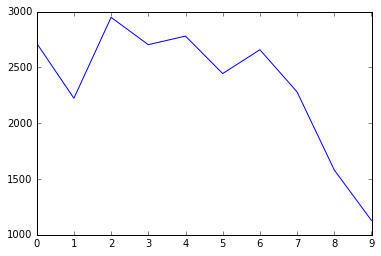

In [69]:
plot_data['average'].plot()

In [70]:
MEPS_medicaid['yes_to_md'] = np.where(MEPS_medicaid.TOTMCD14!=0, 1, 0)

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [71]:
MEPS_medicaid = MEPS_medicaid[MEPS_medicaid.yes_to_md==1]

In [72]:
MEPS_medicaid.SEX = np.where(MEPS_medicaid.SEX=='2 FEMALE', 'Female', 'Male')

In [73]:
MEPS_medicaid.REGION14 = MEPS_medicaid.REGION14.str.split(' ', expand=True, n = 1).get(1).values
MEPS_medicaid.REGION14 = MEPS_medicaid.REGION14.str.capitalize()

In [2]:
CPS = pd.read_csv('/Users/Amy/Dropbox/OSPC - Shared/CPS/cpsmar2014t.csv')

/Users/Amy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (5,23,24,29,83,265,282) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
medicaid_columns = ['mcaid','peridnum','marsupwt', 'wsal_val', 'a_age', 'a_sex', 'gereg', 'h_seq','povll']
CPS = CPS[medicaid_columns]

In [7]:
# impute enrollee 
CPS['MD_enrollment'] = np.where(CPS.mcaid=='Yes', 1, 0)

In [17]:
random.seed(1)

In [25]:
below_124 = (CPS.povll=='1.00 to 1.24')|(CPS.povll=='.75 to .99')|(CPS.povll=='Under .50')|(CPS.povll=='.50 to .74')
imputed_total = 0
while imputed_total < (63 - 54.1) * 1000000:
    not_enrolled = (CPS.MD_enrollment==0)
    candidates = CPS.peridnum[below_124&not_enrolled]
    
    rand = random.randint(1, len(candidates))
    index = candidates.index[rand-1]
    CPS.MD_enrollment[CPS.peridnum==candidates[index]] = 2
    
    imputed_total += int(CPS.marsupwt[CPS.peridnum==candidates[index]])

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
CPS.marsupwt[CPS.MD_enrollment!=0].sum()

62983987.130000785

In [29]:
CPS.wsal_val = np.where(CPS.wsal_val=="None or not in universe", 0, CPS.wsal_val)
CPS.wsal_val = pd.to_numeric(CPS.wsal_val)

In [30]:
CPS.a_age = np.where(CPS.a_age == "80-84 years of age",
                     random.randrange(80, 84),
                     CPS.a_age)
CPS.a_age = np.where(CPS.a_age == "85+ years of age",
                     random.randrange(85, 95),
                     CPS.a_age)
CPS.a_age = pd.to_numeric(CPS.a_age)

In [31]:
CPS['MEPS_ID'] = np.zeros(len(CPS))

In [32]:
CPS = CPS[CPS.MD_enrollment!=0]

In [33]:
len(CPS)

29862

In [34]:
Region = ['Northeast', 'South', 'Midwest', 'West']
Gender = ['Male', 'Female']

In [76]:
for this_area in Region:
    for this_gender in Gender:
        subset_CPS = CPS[(CPS.gereg==this_area)*(CPS.a_sex==this_gender)]
        MEPS_donor = MEPS_medicaid[(MEPS_medicaid.REGION14==this_area)*(MEPS_medicaid.SEX==this_gender)]
        
        for i, record in subset_CPS.iterrows():
            age_range = [record.a_age - 2, record.a_age + 2]
            income_range = [record.wsal_val - 100, record.wsal_val + 100]
            
            f1 = (MEPS_donor.AGE14X >= age_range[0])
            f2 = (MEPS_donor.AGE14X <= age_range[1])
            f3 = (MEPS_donor.WAGEP14X >= income_range[0])
            f4 = (MEPS_donor.WAGEP14X <= income_range[1])
            pool = MEPS_donor[f1 * f2 * f3 * f4]
            
            number_donors = len(pool)
                
            if number_donors < 1:
                # release income constraints and find the person w/ closest income
                pool = MEPS_donor[f1 * f2]
                number_donors = len(pool)
                
                if number_donors < 1:                    
                    if record.a_age < 85:
                        print 'dont have anyone in this age range'
                        print age_range
                        continue
                    else:
                        pool = MEPS_medicaid[MEPS_medicaid.AGE14X==85]

                closest_wage = min(pool.WAGEP14X, key=lambda x:abs(x-record.wsal_val))
                CPS.MEPS_ID[CPS.peridnum==record.peridnum] = pool.DUPERSID[pool.WAGEP14X==closest_wage].values[0]    

            else:
                row_number = random.randint(1, number_donors) - 1
                index = pool.DUPERSID.index[row_number]
                CPS.MEPS_ID[CPS.peridnum==record.peridnum] = pool.DUPERSID.loc[index] 

/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Amy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
CPS.marsupwt[CPS.MEPS_ID!=0].sum()

62983987.130000785

In [78]:
CPS['DUPERSID'] = CPS.MEPS_ID
CPS = pd.merge(CPS, MEPS_medicaid, on='DUPERSID', how='left')

In [79]:
Matched_total = (CPS.marsupwt*CPS.TOTMCD14)[CPS.MEPS_ID!=0].sum()/1000000000

In [80]:
print Matched_total

168.847450234


In [81]:
Medicaid_total_noninstitutional = 468.8 - 71.2
ratio = Medicaid_total_noninstitutional/Matched_total

In [82]:
CPS["MedicaidX"] = np.zeros(len(CPS))
CPS.MedicaidX = CPS.TOTMCD14 * ratio

In [88]:
CPS[['peridnum', 'MedicaidX', 'MD_enrollment']].to_csv('medicaid14.csv', index=False)